In [1]:
from env import GridEnvDeform, create_maze
from dqn import DQNAgent
from logger import Logger
from belief import belief_entropy, update_belief

import torch
from tqdm import tqdm
from tqdm.auto import trange
import os
import argparse
import itertools
import numpy as np
import time

# maze size
N = 2

# thetas deformations (range(a,b),range(c,d))
l0 = 1
h0 = 3
l1 = 1
h1 = 2


In [2]:
class POMDPWrapper_v0():
    """This is a wrapper for the GridEnvDeform class that makes the environment partially observable."""

    def __init__(self, env: GridEnvDeform, agent : DQNAgent, T,O,R,*args, **kwargs):

        self.env = env
        self.agent = agent
        self.states = [((x,y,phi),(i,j)) for x in range(1,env.max_shape[0]-1) for y in range(1,env.max_shape[1]-1) for phi in range(4) for i in range(l0,h0) for j in range(l1,h1)] 
        self.actions = [0,1,2,3]
        self.observations = list(itertools.product([0,1], repeat=5))
        self.thetas = env.deformations

        self.obs_dict = {obs : i for i, obs in enumerate(self.observations)}
        self.state_dict = {state : i for i, state in enumerate(self.states)}
        
        # Transition, Observation and Reward model T(S,A,S'), O(S,A,O), R(S,A,S')
        self.T = T
        self.O = O
        self.R = R
    
    def step(self, s,a):
        s_prime = torch.argmax(self.T[s,a,:])
        r = self.R[s,a,s_prime]
        obs = torch.argmax(self.O[s_prime,0,:])
        info = {"actual_state": s_prime.item()}

        # done = True if np.all(self.states[s_prime.item()][0][:2] == self.env.goal_pos) else False
        done = True if r.item() == 10 else False
        
        return obs.item(), r.item(), done , info 
    
    def run(self, num_trajectories):
        """ 
        The idea is to run the environment to populate the replay buffer with some data
        transition for the POMDP should be like (belief, action, reward, next_belief, done)
        
        repeat
        
        Initialize belief if new episode
        for all actions compute b,a,b',r and store in replay buffer
        execute the best action in the environment
        get new belief 
        
        until populated replay buffer
        
        """


        # create a list of trajectories
        trajectories = []

        # Initialize belief (uniform distribution for now, probably need to change this)
        b = (torch.ones(len(self.states)) / len(self.states))
        s = np.random.randint(0,len(self.states))

        while len(trajectories) < num_trajectories:
            for a in self.env.actions:
                next_obs, reward, done, _ = self.step(s, a)
                b_prime = self.update_belief(b, a, next_obs)

                # format state as dqn agent expects
                # state['obs'] = b (percieved state)
                # state['raw_legal_actions'] = actions
                # state['legal_actions'] = actions
                la =  {i:i for i in range(4)}
                state = {'obs':b, 'raw_legal_actions':la, 'legal_actions':la}
                next_state = {'obs':b_prime, 'raw_legal_actions':la, 'legal_actions':la}

                # Store trajectory
                # trajectories.append(({'obs':b}, a, reward, {'obs':b_prime}, done))
                trajectories.append((state, a, reward, next_state, done))

            # step in the environment
            best_action = self.agent.step(state)    
            next_obs, _, done, info = self.step(s,best_action)
            b = self.update_belief(b, best_action, next_obs)
            s = info['actual_state']
            # if done:
            #     s = np.random.randint(0,len(self.states))
            #     b = (torch.ones(len(self.states)) / len(self.states))
        
        return trajectories

   

    def update_belief(self, belief, action, observation):
        """
        Perform a Bayesian belief update in a POMDP with action-dependent transition and observation models.

        Parameters:
            belief (torch.Tensor): Initial belief distribution over states, shape (num_states,)
            T (torch.Tensor): Transition probabilities, shape (num_states, num_actions, num_states)
            O (torch.Tensor): Observation probabilities, shape (num_states, num_actions, num_observations)
            action (int): The action taken (index of action)
            observation (int): The observation received (index of observation)

        Returns:
            torch.Tensor: The updated belief over states, shape (num_states,)
        """
        # Prediction Step: Compute predicted belief over next states
        predicted_belief = torch.matmul(belief, self.T[:, action])

        # Update Step: Multiply by observation likelihood
        observation_likelihood = self.O[:, action, observation]
        new_belief = predicted_belief * observation_likelihood

        # Normalize the updated belief to ensure it's a valid probability distribution
        if new_belief.sum() > 0:
            new_belief /= new_belief.sum() 
             
        return new_belief        


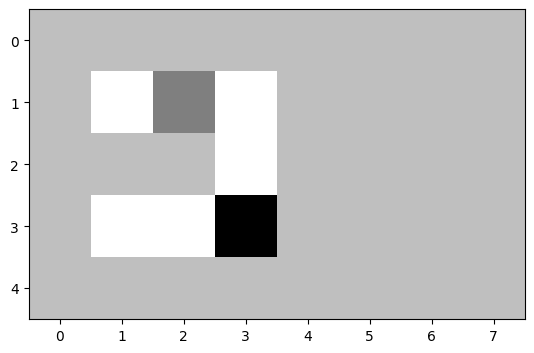

In [3]:
maze = create_maze(N)
env = GridEnvDeform(maze,l0,h0,l1,h1)
env.render()

In [4]:
states = [((x,y,phi),(i,j)) for x in range(1,env.max_shape[0]-1) for y in range(1,env.max_shape[1]-1) for phi in range(4) for i in range(l0,h0) for j in range(l1,h1)] 
actions = [0,1,2,3]
obs = list(itertools.product([0,1], repeat=5))
thetas = [(i,j) for i in range(l0,h0) for j in range(l1,h1)]

state_dict = {state: i for i, state in enumerate(states)}
obs_dict = {obs : i for i, obs in enumerate(obs)}

# Actions are: 0-listen, 1-open-left, 2-open-right
lenS = len(states)
lenA = len(actions)
lenO = len(obs)

print(f"States: {lenS}, Actions: {lenA}, Observations {lenO}, Thetas {thetas}\n")


print("setting reward function\n")
R = torch.zeros(lenS,lenA,lenS)
for s in range(lenS):
    for a in range(lenA):
        r = env.R(states[s],a)
        for s_ in range(lenS):
            R[s][a][s_] = r

print("setting transition function\n")
T = torch.zeros(lenS,lenA,lenS)
for s, state in enumerate(states):
    for a, action in enumerate(actions):
        for s_, state_ in enumerate(states):
            T[s,a,s_] = env.T(state,action,state_)

print("setting observation function\n")
O = torch.zeros(lenS,lenA,lenO)
for s, state in enumerate(states):
    for o, observation in enumerate(obs):
        prob = env.O(state,action,observation)
        for a, action in enumerate(actions):
            O[s,a,o] = prob 



print("transition probability shape: ", T.shape)
print("reward shape: ", R.shape)
print("observation shape: ", O.shape)


States: 144, Actions: 4, Observations 32, Thetas [(1, 1), (2, 1)]

setting reward function

setting transition function

setting observation function

transition probability shape:  torch.Size([144, 4, 144])
reward shape:  torch.Size([144, 4, 144])
observation shape:  torch.Size([144, 4, 32])


In [5]:
def parse():
    parser = argparse.ArgumentParser("DQN for POMDPs Parser")

    parser.add_argument(
        '--cuda',
        type=str,
        default='cpu',
    )
    parser.add_argument(
        '--seed',
        type=int,
        default=42,
    )
    parser.add_argument(
        '--num_episodes',
        type=int,
        default=1000,
    )
    parser.add_argument(
        '--num_eval_games',
        type=int,
        default=500,
    )
    parser.add_argument(
        '--evaluate_every',
        type=int,
        default=5000,
    )
    parser.add_argument(
        '--log_dir',
        type=str,
        default='logs/',
    )

    parser.add_argument(
        "--load_checkpoint_path",
        type=str,
        default="",
    )

    parser.add_argument(
        "--save_every",
        type=int,
        default=25000
    )

    parser.add_argument(
        "--f",
        type=str,
        default="",
    )
    args = parser.parse_args()

    os.environ["CUDA_VISIBLE_DEVICES"] = args.cuda

    # create directory if not exists
    if not os.path.exists(args.log_dir):
        os.makedirs(args.log_dir)


    return args

args = parse()

In [6]:

info = [f'num_episodes: {args.num_episodes}',
        f'evaluate_every: {args.evaluate_every}',
        f'num_eval_games: {args.num_eval_games}',
        f'save_every (checkpoints): {args.save_every}',
        f'log_dir: {args.log_dir}',
        f'load_checkpoint_path: {args.load_checkpoint_path}',
        f'seed: {args.seed}'
    ]

with Logger(args.log_dir) as logger:
        logger.log_info(info)
        

# Check whether gpu is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE :", device)  


# Initialize the agent and use random agents as opponents
agent = DQNAgent(
    num_actions=4,
    state_shape=(len(states),),
    mlp_layers=[64,64],
    device=device,
    save_path=args.log_dir,
    save_every=args.save_every,
    replay_memory_size=500,
    replay_memory_init_size=100,
    batch_size=64,  # batch size always less than initmemorysize

)

env_wrapper = POMDPWrapper_v0(env, agent, T, O, R)
   
if args.load_checkpoint_path != "":
        dirs = os.listdir(args.load_checkpoint_path)
        
        dirs = [d for d in dirs if d.startswith("checkpoint")]
        if dirs != []:
            
            dirs = sorted(dirs, key=lambda x: int(x.split("-")[1].split(".")[0]))
            path = args.load_checkpoint_path + "/" + dirs[-1] if len(dirs) > 0 else None
        
            agent = agent.from_checkpoint(checkpoint=torch.load(path))
            agent.save_every = args.save_every
            agent.save_path = args.log_dir


start_episode = agent.train_t
# Start training
with Logger(args.log_dir) as logger:
    for episode in trange(args.num_episodes):
        if episode < start_episode:
            continue

        # Generate data from the environment
        # payoffs: tuple (list of game payoffs, [player0's round_payoff, player1's round_payoff])
        trajectories = env_wrapper.run(32)

        # Reorganaize the data to be ts = state, action, reward, next_state, done
        # Feed transitions into agent memory, and train the agent
        for ts in trajectories:
            agent.feed(ts)


        # Evaluate the performance. Play with random agents.
        if episode % args.evaluate_every == 0:                
            pass


# Save model
save_path = os.path.join(args.log_dir, 'model.pth')
torch.save(agent, save_path)
print('Model saved in', save_path)


----------------------------------------
num_episodes: 1000
evaluate_every: 5000
num_eval_games: 500
save_every (checkpoints): 25000
log_dir: logs/
load_checkpoint_path: 
seed: 42
----------------------------------------

Logs saved in logs/
DEVICE : cpu


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO - Step 100, rl-loss: 10.564167022705078
INFO - Copied model parameters to target network.
INFO - Step 10100, rl-loss: 3.25487923622131354
INFO - Copied model parameters to target network.
INFO - Step 20100, rl-loss: 5.3771448135375984
INFO - Copied model parameters to target network.
INFO - Step 25099, rl-loss: 25.253240585327152
INFO - Saved model checkpoint.
INFO - Step 30100, rl-loss: 47.009536743164069
INFO - Copied model parameters to target network.
INFO - Step 32000, rl-loss: 195.38777160644535
Logs saved in logs/
Model saved in logs/model.pth


Initial state:  ((1, 3, 1), (1, 1))


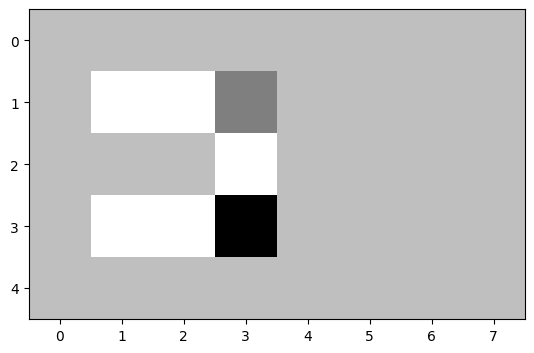

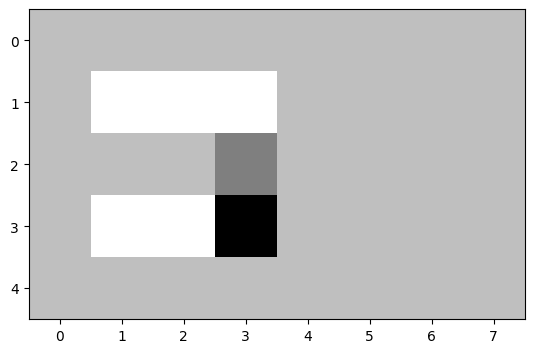

Step:  14
Timestep missing: 14  
Total reward:     -0.02500000037252903  
Chosen action:  1
Actual State:  ((2, 3, 2), (1, 1))
argmax and max Belief:  ((1, 2, 1), (1, 1)) tensor(0.1667)
Belief entropy:  2.5849626064300537


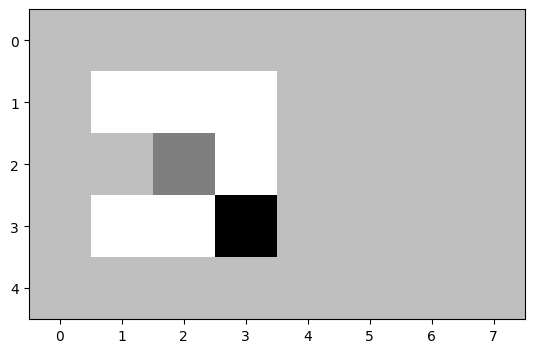

Step:  13
Timestep missing: 13  
Total reward:     -1.275000000372529  
Chosen action:  1
Actual State:  ((2, 2, 3), (1, 1))
argmax and max Belief:  ((2, 2, 1), (2, 1)) tensor(0.5000)
Belief entropy:  1.0


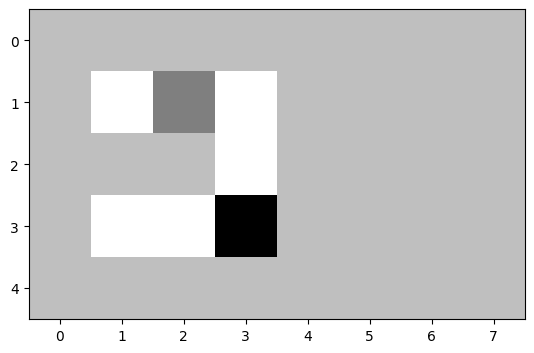

Step:  12
Timestep missing: 12  
Total reward:     -1.300000000745058  
Chosen action:  1
Actual State:  ((1, 2, 0), (1, 1))
argmax and max Belief:  ((1, 2, 0), (1, 1)) tensor(0.5000)
Belief entropy:  1.0


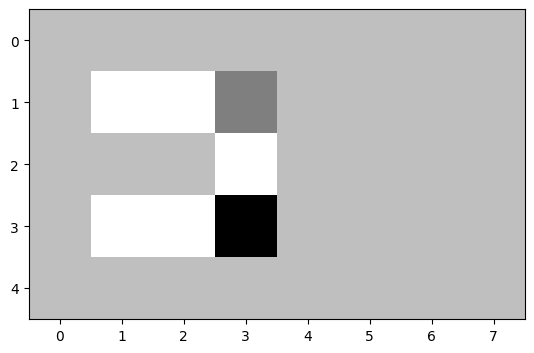

Step:  11
Timestep missing: 11  
Total reward:     -1.325000001117587  
Chosen action:  1
Actual State:  ((1, 3, 1), (1, 1))
argmax and max Belief:  ((1, 3, 1), (1, 1)) tensor(1.)
Belief entropy:  -0.0


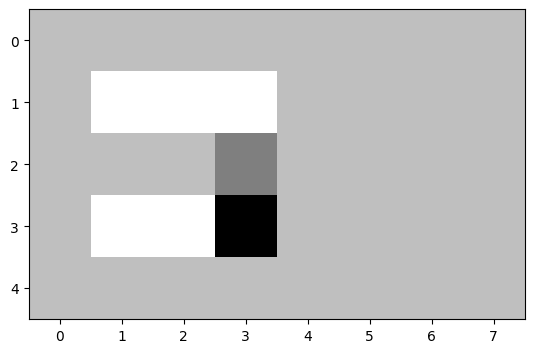

Step:  10
Timestep missing: 10  
Total reward:     -1.3500000014901161  
Chosen action:  1
Actual State:  ((2, 3, 2), (1, 1))
argmax and max Belief:  ((2, 3, 2), (1, 1)) tensor(1.)
Belief entropy:  -0.0


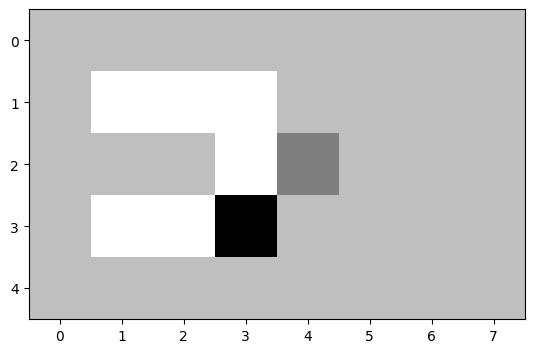

Step:  9
Timestep missing: 9  
Total reward:     -2.600000001490116  
Chosen action:  3
Actual State:  ((2, 4, 1), (1, 1))
argmax and max Belief:  ((2, 4, 1), (1, 1)) tensor(1.)
Belief entropy:  -0.0


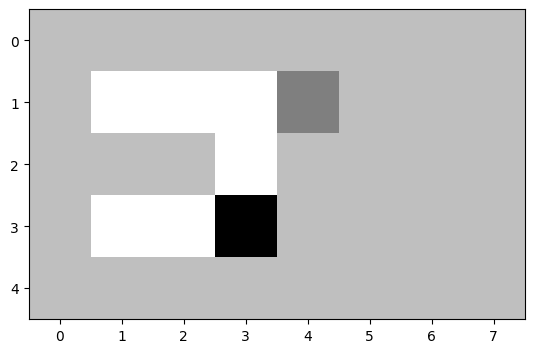

Step:  8
Timestep missing: 8  
Total reward:     -3.850000001490116  
Chosen action:  3
Actual State:  ((1, 4, 0), (1, 1))
argmax and max Belief:  ((1, 4, 0), (1, 1)) tensor(1.)
Belief entropy:  -0.0


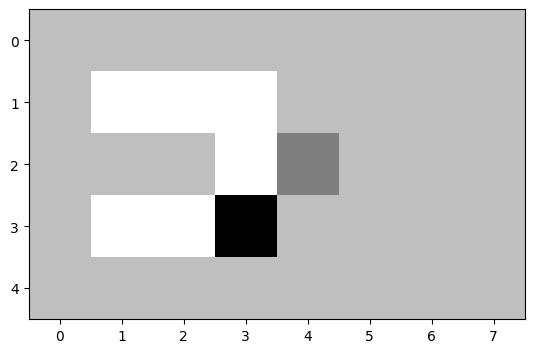

Step:  7
Timestep missing: 7  
Total reward:     -5.100000001490116  
Chosen action:  2
Actual State:  ((2, 4, 2), (1, 1))
argmax and max Belief:  ((2, 4, 2), (1, 1)) tensor(1.)
Belief entropy:  -0.0


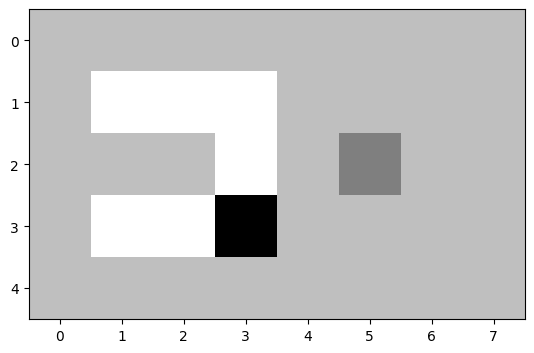

Step:  6
Timestep missing: 6  
Total reward:     -6.350000001490116  
Chosen action:  3
Actual State:  ((2, 5, 1), (1, 1))
argmax and max Belief:  ((2, 5, 1), (1, 1)) tensor(1.)
Belief entropy:  -0.0


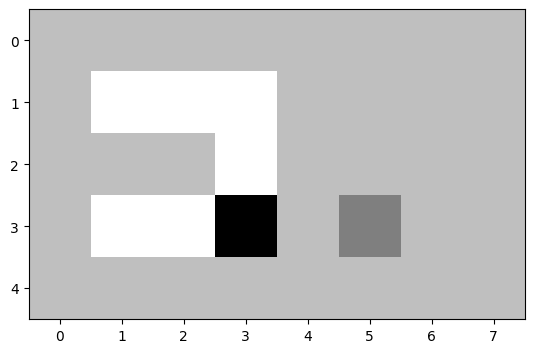

Step:  5
Timestep missing: 5  
Total reward:     -7.600000001490116  
Chosen action:  1
Actual State:  ((3, 5, 2), (1, 1))
argmax and max Belief:  ((3, 5, 2), (1, 1)) tensor(1.)
Belief entropy:  -0.0


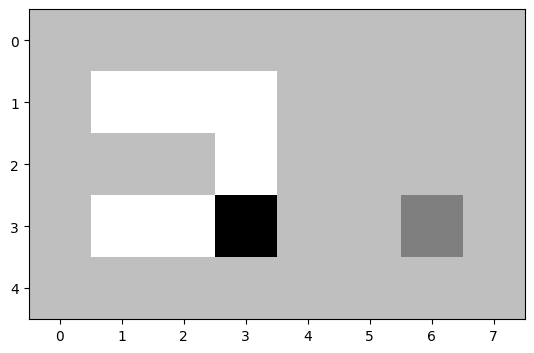

Step:  4
Timestep missing: 4  
Total reward:     -8.850000001490116  
Chosen action:  3
Actual State:  ((3, 6, 1), (1, 1))
argmax and max Belief:  ((3, 6, 1), (1, 1)) tensor(1.)
Belief entropy:  -0.0


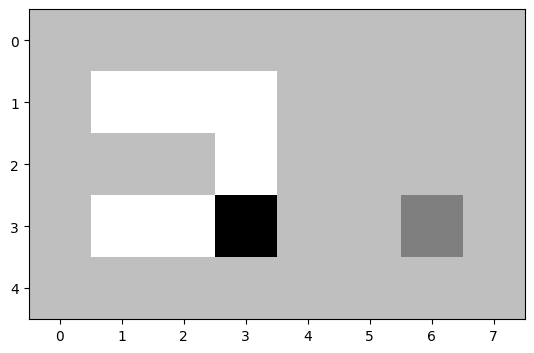

Step:  3
Timestep missing: 3  
Total reward:     -10.100000001490116  
Chosen action:  0
Actual State:  ((3, 6, 1), (1, 1))
argmax and max Belief:  ((3, 6, 1), (1, 1)) tensor(1.)
Belief entropy:  -0.0


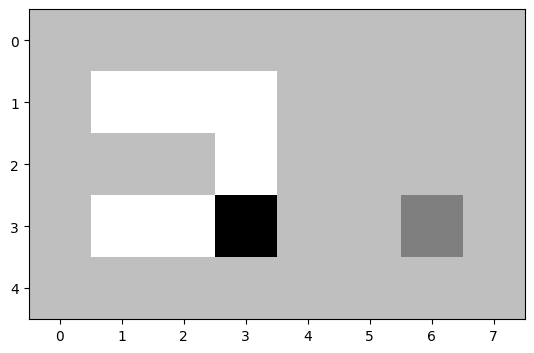

Step:  2
Timestep missing: 2  
Total reward:     -11.350000001490116  
Chosen action:  1
Actual State:  ((3, 6, 2), (1, 1))
argmax and max Belief:  ((3, 6, 2), (1, 1)) tensor(1.)
Belief entropy:  -0.0


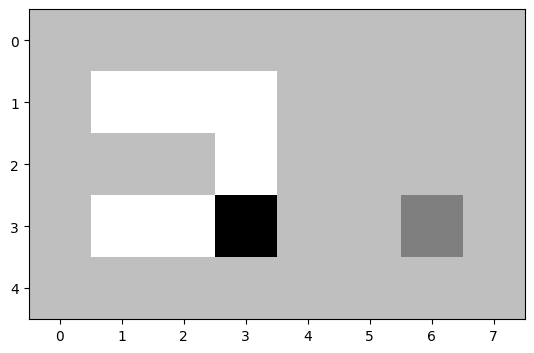

Step:  1
Timestep missing: 1  
Total reward:     -12.600000001490116  
Chosen action:  3
Actual State:  ((3, 6, 1), (1, 1))
argmax and max Belief:  ((3, 6, 1), (1, 1)) tensor(1.)
Belief entropy:  -0.0


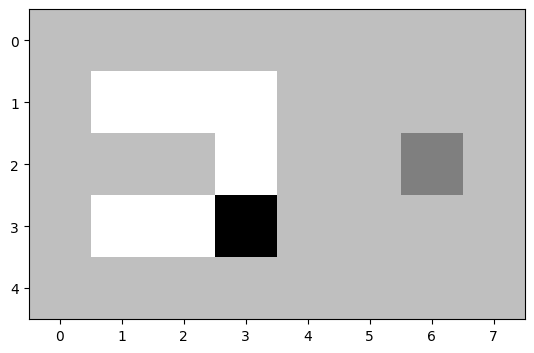

Step:  0
Timestep missing: 0  
Total reward:     -13.850000001490116  
Chosen action:  3
Actual State:  ((2, 6, 0), (1, 1))
argmax and max Belief:  ((2, 6, 0), (1, 1)) tensor(1.)
Belief entropy:  -0.0


In [8]:
# the simulation starts with given belief and random state
b = torch.ones(len(states)) / len(states)
s = np.random.randint(len(states))
la =  {i:i for i in range(4)}

print("Initial state: ", states[s])
env.render(states[s])
# obs = env.get_observation(states[s])
# b = env_wrapper.update_belief(b, 0, obs)


horizon = 15
# We loop for each step we have yet to do.
totalReward = 0.0
for t in range(horizon - 1, -1, -1):
    # We advance the world one step (the agent only sees the observation
    # and reward).
    #best_action = agent.eval_step({'obs':b, 'raw_legal_actions':la, 'legal_actions':la})[0]
    best_action = np.random.choice([0,1,2,3])
    next_obs, reward, done, info = env_wrapper.step(s, best_action)
    next_state = info['actual_state']
    totalReward += reward
    env.render(states[next_state])


    next_belief = env_wrapper.update_belief(b, best_action, next_obs)
    
    print("Step: ", t)
    print("Timestep missing: " + str(t) + "  ") # Print space after to clear
    print("Total reward:     " + str(totalReward) + "  ")
    print("Chosen action: ", best_action)
    print("Actual State: ", states[next_state])
    print("argmax and max Belief: ", states[torch.argmax(next_belief)], torch.max(next_belief))
    print("Belief entropy: ", belief_entropy(next_belief))

    if t == 1:
        assert states[torch.argmax(next_belief)] == states[next_state] 
    
    # Then we update the world
    s = next_state
    b = next_belief
    # Sleep 1 second so the user can see what is happening.
    time.sleep(1)



# Belief update testing

In [5]:
agent = DQNAgent(
    num_actions=4,
    state_shape=(len(states),),
    mlp_layers=[64,64],
    device='cpu',
    replay_memory_size=500,
    replay_memory_init_size=100,
    batch_size=64,  # batch size always less than initmemorysize

)

env_wrapper = POMDPWrapper_v0(env, agent, T, O, R)


[Flatten(start_dim=1, end_dim=-1), BatchNorm1d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), Linear(in_features=144, out_features=64, bias=True), ReLU(), Linear(in_features=64, out_features=64, bias=True), ReLU(), Linear(in_features=64, out_features=4, bias=True)]
[Flatten(start_dim=1, end_dim=-1), BatchNorm1d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), Linear(in_features=144, out_features=64, bias=True), ReLU(), Linear(in_features=64, out_features=64, bias=True), ReLU(), Linear(in_features=64, out_features=4, bias=True)]


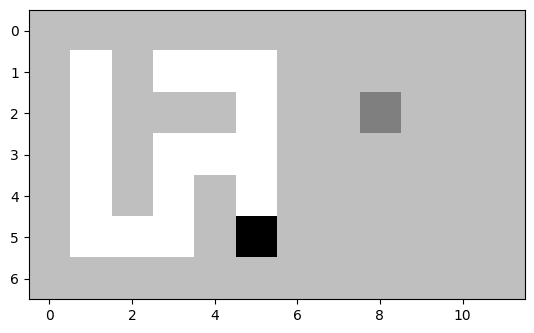

In [49]:
env.render()

In [6]:
belief = torch.ones(len(states)) / len(states)
action = 1
observation = 31

In [14]:
"""
Perform a Bayesian belief update in a POMDP with action-dependent transition and observation models.

Parameters:
    belief (torch.Tensor): Initial belief distribution over states, shape (num_states,)
    transition_matrix (torch.Tensor): Transition probabilities, shape (num_states, num_actions, num_states)
    observation_matrix (torch.Tensor): Observation probabilities, shape (num_states, num_actions, num_observations)
    action (int): The action taken (index of action)
    observation (int): The observation received (index of observation)

Returns:
    torch.Tensor: The updated belief over states, shape (num_states,)
"""
# Prediction Step: Compute predicted belief over next states
predicted_belief = torch.matmul(belief, T[:, action])

# Update Step: Multiply by observation likelihood
observation_likelihood = O[:, action, observation]
updated_belief = predicted_belief * observation_likelihood

# Normalize the updated belief to ensure it's a valid probability distribution
if updated_belief.sum() > 0:
    updated_belief /= updated_belief.sum() 



Initial state:  ((1, 7, 3), (1, 1))


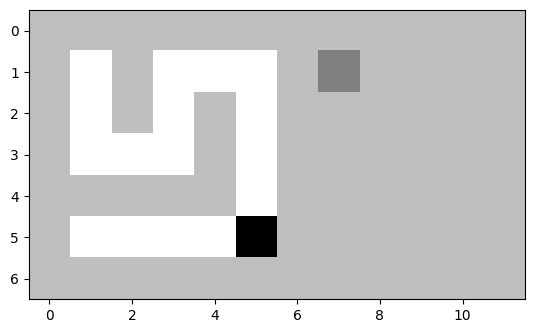

In [6]:
# the simulation starts with given belief and random state
b = torch.ones(len(states)) / len(states)
s = np.random.randint(len(states))


i = 54

print("Initial state: ", states[i])
env.render(states[i])


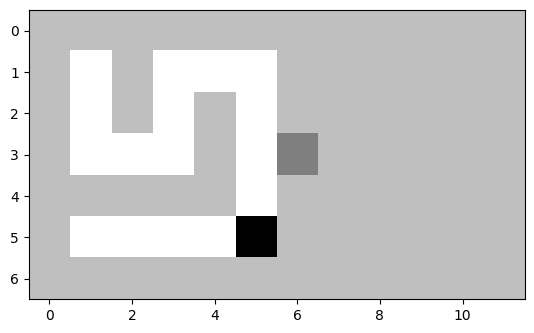

In [24]:
# the simulation starts with given belief and random state
b = torch.ones(len(states)) / len(states)
s = np.random.randint(len(states))

env.render(states[s])